In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import seaborn as sns

In [38]:
# setup directories

datadir = '/home/xavier/data/claims/'

# year12 = 'Medicare_Provider_Util_Payment_PUF_CY2012.txt'
# year13 = 'Medicare_Provider_Util_Payment_PUF_CY2013.txt'
# year14 = 'Medicare_Provider_Util_Payment_PUF_CY2014.txt'
year15 = 'Medicare_Provider_Util_Payment_PUF_CY2015.txt'

cancer_doctor_types = 'cancer_doctor_types.csv'

fields_lowercase = ['npi','nppes_provider_street1','nppes_provider_street2','provider_type','hcpcs_code','hcpcs_description','line_srvc_cnt']



# Medicare Provider Utilization and Payment Data: Physician and Other Supplier PUF CY2015


> The Centers for Medicare & Medicaid Services (CMS) has prepared a public data set, the Provider Utilization and Payment Data Physician and Other Supplier Public Use File (herein referred to as “Physician and Other Supplier PUF”), with information on services and procedures provided to Medicare beneficiaries by physicians and other healthcare professionals. T

+ this Public Dataset [can be downloaded](https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/sk9b-znav)
+ What's in this DataSet?

| Rows | Columns | Each row is a | 
| - - - | - - - | - - - | 
| 9.5M | 26 | Physician/HCPCS | 





In [3]:
# load all physican data
df15 = pd.read_csv(datadir + year15, usecols=fields_lowercase, sep='\t', lineterminator='\n')

In [52]:
# load the physican types which are marked as "likely to treat cancer"
# (NOTE: this was an arbitrary selection, but seems decent to start with)
all_treaters = pd.read_csv(datadir + cancer_doctor_types)
marked_cancer = all_treaters[all_treaters["CANCER_TESTS"]=="yes"]
cancer_treater_list = marked_cancer.PROVIDER_TYPE
cancer_treater_list

1                           Internal Medicine
15                        Hematology/Oncology
18                                  Pathology
21                        Clinical Laboratory
29                         Radiation Oncology
35                           Medical Oncology
44    Independent Diagnostic Testing Facility
62                     Gynecological/Oncology
64                                 Hematology
Name: PROVIDER_TYPE, dtype: object

In [6]:
# list the loaded column names 
list(df15)

['npi',
 'nppes_provider_street1',
 'nppes_provider_street2',
 'provider_type',
 'hcpcs_code',
 'hcpcs_description',
 'line_srvc_cnt']

In [7]:
df15.head()

,npi,nppes_provider_street1,nppes_provider_street2,provider_type,hcpcs_code,hcpcs_description,line_srvc_cnt
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1003000126,900 SETON DR,NaN,Internal Medicine,99217,Hospital observation care discharge,23.0
2,1003000126,900 SETON DR,NaN,Internal Medicine,99219,Hospital observation care typically 50 minutes,18.0
3,1003000126,900 SETON DR,NaN,Internal Medicine,99221,"Initial hospital inpatient care, typically 30 ...",59.0
4,1003000126,900 SETON DR,NaN,Internal Medicine,99222,"Initial hospital inpatient care, typically 50 ...",132.0


# Starting with the Topline: 
## 1) Types of HCPs in dataset
## 2) Oncologist & Pathologist claims vs total claims

In [35]:
# find all doctor types
all_doctors = df15.groupby("provider_type").size().reset_index(name='count')
all_doctors.sort_values(by='count', ascending=False,inplace=True)
all_doctors.shape

(91, 2)

In [36]:
# Export doctors types
# all_doctors.to_csv(datadir + 'all_doctor_types.csv')

In [31]:
# group Top 20 doctor types
top_doctor_types = all_doctors.head(21)

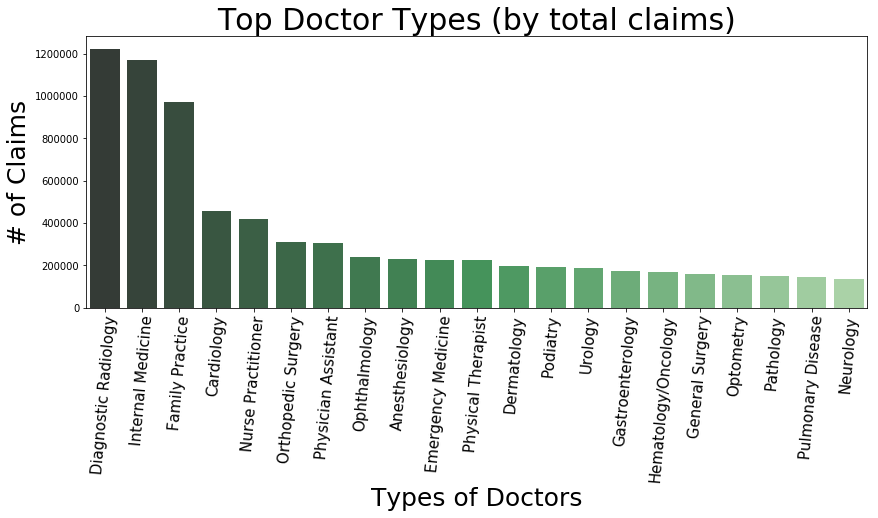

In [33]:
# Plot the Top 20 Doctor types (making the most claims) 
width=14
height=5
figure(figsize=(width,height))

ax = sns.barplot(x=top_doctor_types["provider_type"], y=top_doctor_types["count"],palette="Greens_d")

plt.xticks(rotation= 85,fontsize=15)
plt.xlabel('Types of Doctors',fontsize=25)
plt.ylabel('# of Claims',fontsize=25)
plt.title('Top Doctor Types (by total claims)',fontsize=30)

# Show the plot
plt.show()

### FINDING ➜ Pathologists & Oncologists make it into the Top 20 (of total claims, by Doctor Type)

In [82]:
# sum up to the total number
# of claims for ALL doctors vs. CANCER TREATERS

total_claims = df15.line_srvc_cnt.sum()
cancer_treaters = df15.loc[df15['provider_type'].isin(cancer_treater_list)]
cancer_claims = cancer_treaters.line_srvc_cnt.sum()

In [83]:
# prepare to plot this
raw_data = {'CLAIMS': ['Claims from All Doctors', 'Claims from Cancer Treaters'], 
        'AMOUNT': [total_claims, cancer_claims]}
claims_comparison = pd.DataFrame(raw_data, columns = ['CLAIMS', 'AMOUNT'])
claims_comparison

,CLAIMS,AMOUNT
0,Claims from All Doctors,2.359294e+09
1,Claims from Cancer Treaters,9.218618e+08


Text(0.5,1,'Total Claims vs. Cancer Treater Claims')

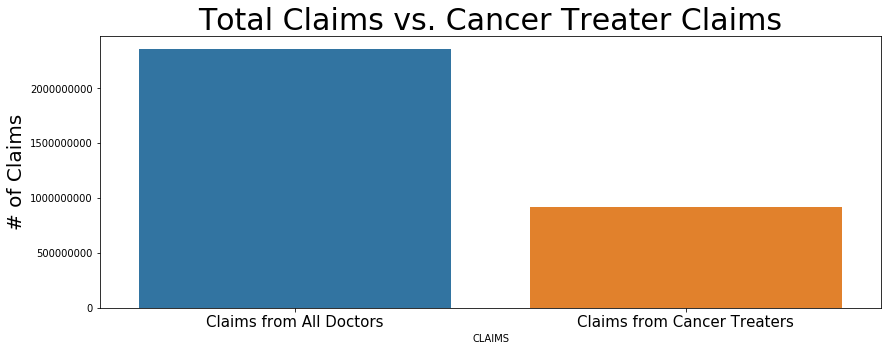

In [91]:
# Plot the Total Claims vs. the Cancer Claims 
width=14
height=5
figure(figsize=(width,height))

p = sns.barplot(x=claims_comparison["CLAIMS"], y  = claims_comparison["AMOUNT"])

plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=15)
plt.ylabel('# of Claims',fontsize=20)
plt.title('Total Claims vs. Cancer Treater Claims',fontsize=30)




### FINDING ➜ When comparing the claims from Doctors most likley to test for cancer to the total, a surprising number of the claims cames from Cancer Treaters. 

+ This is likely because "Cancer Treaters" includes the broad category of **"Internal Medicine"**, adding a lot of bulk to that number 

- - -
# Next, looking at "Cancer Treater" services: 
## 1) Top Oncologist / Pathologist Services...
## 2) ...compared to top genetic tests by same doctors

In [ ]:
# genetic12 = df12[df12['HCPCS_DESCRIPTION'].str.contains("genetic", na=False)]

In [ ]:
df15.head(10)

In [ ]:
list(df15)

In [ ]:
genetic15 = df15[df15['hcpcs_description'].str.contains("genetic", na=False)]

In [ ]:
test_type15 = genetic15.groupby('hcpcs_description').size().reset_index(name='count')
test_type15.sort_values(by='count', ascending=False,inplace=True)
test_type15

In [ ]:
tumors15 = genetic15[genetic15['hcpcs_description'].str.contains("Microscopic genetic analysis of tumor", na=False)]
tumors15.groupby('provider_type').size()

In [ ]:
report15 = genetic15[genetic15['hcpcs_description'].str.contains("Interpretation and report of genetic testing", na=False)]
report15.groupby('provider_type').size()

In [ ]:
tumors15

In [ ]:
# List the addresses of tumor claims

tumors15.nppes_provider_street1

## LOAD THE 215 RESEARCH CLINICS, TO MATCH ADDRESSES



In [ ]:
research = pd.read_csv(datadir + '215_research_clinics.csv')
research.shape

In [ ]:
# convert two address columns to Series
research_mailing_address = pd.Series(research['Mailing Address'])
research_practice_address = pd.Series(research['Practice Address'])

In [ ]:
# perform matching
(
    tumors15.nppes_provider_street1.isin(research_mailing_address) |
    tumors15.nppes_provider_street1.isin(research_practice_address)
).value_counts()

So of the **4126** tumor tests, 12 came from research clinics

In [ ]:
(
    genetic15.nppes_provider_street1.isin(research_mailing_address) |
    genetic15.nppes_provider_street1.isin(research_practice_address)
).value_counts()

# LOAD THE 25,659 Oncology clinics, to match addresses

In [ ]:
onclinics = pd.read_csv(datadir + '25K-oncology-deduped.csv')
onclinics.shape

In [ ]:
list(onclinics)

In [ ]:
onclinic_address = pd.Series(onclinics.ADDRESS)

In [ ]:
onclinic_address

In [ ]:
genetic15.nppes_provider_street1.isin(onclinic_address).value_counts()

In [ ]:
3293+3236

In [ ]:
# convert two address columns to Series
onclinics_mailing_address = pd.Series(onclinics['Mailing Address'])
onclinics_practice_address = pd.Series(onclinics['Practice Address'])

In [ ]:
# perform matching
(
    tumors15.nppes_provider_street1.isin(onclinics_mailing_address) |
    tumors15.nppes_provider_street1.isin(onclinics_practice_address)
).value_counts()

In [ ]:
list(onclinics)

In [ ]:
1952+2174

In [ ]:
tumors15.nppes_provider_street1.isin(research_practice_address).value_counts()

In [ ]:
peachtree = tumors15.nppes_provider_street1.str.contains("1968 PEACHTREE RD NW")
tumors15[peachtree]

In [ ]:
tumors15.nppes_provider_street1.isin(["1968 PEACHTREE RD NW","1 MEDICAL CENTER DR"]).value_counts()

In [ ]:
entities = df15.groupby('nppes_entity_code').size().reset_index(name='count')
entities.sort_values(by='count', ascending=False,inplace=True)
entities

In [ ]:
providers = df15.groupby('provider_type').size().reset_index(name='count')
providers.sort_values(by='count', ascending=False,inplace=True)
providers